In [33]:
Alpha_Name = "AlphaNet_Original_Input_12.22_1d_return_normalized"
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/result/"
target = "1d_ret"

In [24]:
from os import walk
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import torch.utils.data as Data
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import time
import multiprocessing as mp
from os import walk
import matplotlib.pyplot as plt
feat_num = 9

In [25]:
time_list = []
data_path = path + "Data/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
time_list

100%|██████████| 26/26 [00:00<00:00, 170660.26it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par',
 '2020-01-01_2020-03-01.par',
 '2020-03-01_2020-06-01.par',
 '2020-06-01_2020-09-01.par',
 '2020-09-01_2021-01-01.par',
 '2021-01-01_2021-03-01.par',
 '2021-03-01_2021-06-01.par']

In [49]:
train_timestamp = time_list[:15]
test_timestamp = time_list[17:21]
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)

for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 15/15 [00:32<00:00,  2.19s/it]


,,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,5.351201,0.267430,0.227619,5.701988,0.455030,0.158384,6.926264,0.263875,0.036162,5.824307,...,2.011997,-0.234840,-0.631511,-1.306780,-0.339877,-0.743334,-0.971280,0.083746,-0.546152,-0.910757
2015-02-17 09:30:00,1,5.945336,0.481935,0.220847,6.276283,0.495895,0.166158,7.386646,0.524170,0.027803,6.552703,...,2.010377,-1.101398,-1.252146,-1.334313,-0.348708,-0.786997,-1.008220,0.062658,-0.612285,-0.956416
2015-02-25 09:30:00,1,5.574740,0.462953,0.277408,6.239022,0.577972,0.232010,7.388862,0.386684,0.072353,6.120460,...,1.981707,-0.751728,-1.019505,-1.278489,-0.419623,-0.840248,-1.082287,-0.060606,-0.696508,-1.053548
2015-02-26 09:30:00,1,5.415807,0.304391,0.498564,6.546736,0.310639,0.431279,7.113693,0.301327,0.210055,6.291341,...,1.960241,-1.183736,-1.222458,-1.261726,-0.472570,-0.897367,-1.176503,-0.145279,-0.783414,-1.194604
2015-02-27 09:30:00,1,7.127998,0.250718,0.163448,7.165038,0.210522,0.323123,8.395182,0.163757,0.181473,7.727388,...,1.956876,-0.307601,-0.865937,-1.268299,-0.602554,-0.897447,-1.213570,-0.348097,-0.776039,-1.235655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27 09:30:00,603999,-0.174942,-0.126734,-0.203870,-0.183324,-0.134643,-0.188757,-0.171436,-0.126324,-0.226296,-0.174153,...,-0.837124,0.731434,0.199326,-0.636095,0.121089,-0.244973,-0.561038,-0.370505,-0.650688,-0.879133
2018-08-28 09:30:00,603999,-0.128567,-0.132518,-0.183274,-0.141449,-0.141803,-0.187733,-0.127230,-0.130975,-0.229429,-0.132940,...,-0.820538,0.952496,0.513298,0.281341,0.026548,-0.271743,-0.532901,-0.456958,-0.677956,-0.867689
2018-08-29 09:30:00,603999,-0.123022,-0.136756,-0.180111,-0.133166,-0.143819,-0.204591,-0.116133,-0.132709,-0.181425,-0.132737,...,-0.819309,1.427103,0.753234,0.162556,-0.068333,-0.277159,-0.532700,-0.536609,-0.680642,-0.870435


timestamp            ticker
2015-02-16 09:30:00  1        -0.705088
2015-02-17 09:30:00  1         0.010739
2015-02-25 09:30:00  1        -0.496705
2015-02-26 09:30:00  1         0.329146
2015-02-27 09:30:00  1        -0.716043
                                 ...   
2018-08-27 09:30:00  603999    0.854030
2018-08-28 09:30:00  603999   -0.146074
2018-08-29 09:30:00  603999    0.368227
2018-08-30 09:30:00  603999   -0.223248
2018-08-31 09:30:00  603999    0.101299
Name: target, Length: 2633778, dtype: float64

100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


,,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2019-03-01 09:30:00,1,5.019400,0.791409,10.561158,3.420118,1.527146,10.486943,2.249188,0.912171,10.884231,3.786842,...,1.777102,1.365906,0.193555,-1.306611,-0.958591,-1.040084,-1.187281,-0.811353,-0.943619,-1.149440
2019-03-04 09:30:00,1,7.620700,0.372544,10.620596,4.571607,0.540378,10.397887,7.155605,0.530258,10.641849,7.510440,...,1.765964,1.443099,0.518007,-1.301826,-0.815756,-0.995143,-1.187279,-0.612248,-0.848885,-1.107364
2019-03-05 09:30:00,1,10.759677,0.374513,11.022646,10.358985,0.625384,10.402356,11.341524,0.443887,10.596902,10.263448,...,1.748850,1.476532,0.521527,-1.280022,-0.799625,-0.999635,-1.186929,-0.576728,-0.847505,-1.088473
2019-03-06 09:30:00,1,10.819485,0.792814,8.266418,10.905645,0.797533,8.297856,11.326990,0.409847,7.479016,10.605827,...,1.725001,1.328313,0.202409,-1.266924,-0.821478,-1.014516,-1.185596,-0.605004,-0.888902,-1.140645
2019-03-07 09:30:00,1,11.261148,0.846636,5.355550,11.465005,0.769249,5.429490,11.692036,0.175325,4.949297,11.374848,...,1.706168,1.301336,-0.115685,-1.283112,-0.824669,-1.025016,-1.186579,-0.607481,-0.925322,-1.194644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24 09:30:00,688399,-0.140521,0.351964,-0.091212,-0.166969,0.161884,-0.120382,-0.145376,0.254730,-0.106309,-0.153576,...,-1.070444,1.473815,0.551618,-1.280151,1.538421,1.518221,1.497944,1.492313,1.480955,1.460790
2020-02-25 09:30:00,688399,-0.130069,0.186705,-0.107732,-0.151317,0.037801,-0.123709,-0.123545,0.088621,-0.116171,-0.137870,...,-1.044061,1.492022,0.269166,-1.208974,1.554928,1.523831,1.491459,1.504209,1.481860,1.449283
2020-02-26 09:30:00,688399,0.408348,0.150296,-0.114781,0.528824,0.024394,-0.126966,0.646709,0.046190,-0.124150,0.489051,...,-1.058096,1.469304,-0.014971,-1.221949,1.558539,1.520871,1.479053,1.505902,1.477116,1.433089


timestamp            ticker
2019-03-01 09:30:00  1         0.210976
2019-03-04 09:30:00  1         0.313131
2019-03-05 09:30:00  1        -0.643310
2019-03-06 09:30:00  1        -0.500139
2019-03-07 09:30:00  1        -1.180464
                                 ...   
2020-02-24 09:30:00  688399    1.771073
2020-02-25 09:30:00  688399    1.498794
2020-02-26 09:30:00  688399   -1.733627
2020-02-27 09:30:00  688399    0.522789
2020-02-28 09:30:00  688399    2.288270
Name: target, Length: 885426, dtype: float64

In [50]:
trainx = torch.from_numpy(np.array(trainx))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([2633778, 648])
trainy.shape:  torch.Size([2633778, 1])
testx.shape:  torch.Size([885426, 648])
testy.shape:  torch.Size([885426, 1])


In [51]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1000
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [30]:
class AlphaNet(nn.Module):
    def __init__(self, factor_num, fully_connect_layer_neural):
        super(AlphaNet, self).__init__()
        self.fc1_neuron = int((factor_num * (factor_num - 1)+ 4 * factor_num) * 3 * 2)
        self.fc2_neuron = fully_connect_layer_neural
        self.batch = torch.nn.BatchNorm1d(self.fc1_neuron)
        self.fc1 = torch.nn.Linear(self.fc1_neuron, self.fc2_neuron)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = self.batch(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.out(x)
        return y_pred
# device=torch.device('cuda:0')

In [40]:
alphanet = AlphaNet(feat_num, 30)
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
LR = 0.001
loss_function = nn.MSELoss().cuda()
optimizer = optim.RMSprop(alphanet.parameters(), lr=LR, alpha=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.5)
epoch_num = 20
loss_list = []
# for epoch in range(epoch_num):
#     optimizer.step()
#     scheduler.step()
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
# plt.plot(range(epoch_num),lr_list,color = 'r')

for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

AlphaNet(
  (batch): BatchNorm1d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=648, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=30, out_features=1, bias=True)
)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: Exception ignored in:     self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
    Traceback (most recent call last):
if w.is_alive():Exception ignored in:   File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive


    Traceback (most recent call last):
    Traceback (most recent call last):

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _

Epoch:  1  loss:  0.907181777045022


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>    
Traceback (most recent call last):
if w.is_alive():Exception ignored in:   File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
    
self._shutdown_workers()Exception ignored in:   File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>  File "/home/

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _

Epoch:  2  loss:  0.9035546165499995


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

Traceback (most recent call last):
      File

        if w.is_alive():self._shutdown_workers()

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError: 
can only test a child process  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _s

Epoch:  3  loss:  0.9017715267838773


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _

AssertionErrorAssertionErrorcan only test a child process    : 

if w.is_alive():can only test a child process
: can only test a child process
    AssertionErrorcan only test a child process  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
: 
    assert self._parent_pid == os.getpid(), 'can only test a child process'
assert self._parent_pid == os.getpid(), 'can only test a child process'can only test a child process

AssertionError: can only test a child process

AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>can only test a child process

Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/li

Epoch:  4  loss:  0.9004412363393807


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in

assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
AssertionErrorAssertionErrorAssertionError    : assert self._parent_pid == os.getpid(), 'can only test a child process': : : can only test a child process
can only test a child process
can only test a child processAssertionErrorcan only test a child process

: 
can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>self._shutdown_workers()

Traceback (most recent cal

Epoch:  5  loss:  0.8995899000563028


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: 

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):
  File "/hom

        assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'    


AssertionErrorself._shutdown_workers()AssertionErrorAssertionError: : : 
can only test a child processcan only test a child processcan only test a child process  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers



    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>AssertionError: 
can only test a child processTraceback (most recent call last):

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._s

Epoch:  6  loss:  0.8990811180222624


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
        if w.is_alive():Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>if w.is_alive():  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.p

assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):


  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionErrorTraceback (most recent call last):
:       File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
can only test a child processself._shutdown_workers()
    
self._shutdown_workers()  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
if w.is_alive():
      File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():
      File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", li

Epoch:  7  loss:  0.8987549164208024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: 
can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):


  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
      File

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

    self._shutdown_workers()Traceback (most recent call last):

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: if w

Epoch:  8  loss:  0.8982061870373546


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _

assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__


assert self._parent_pid == os.getpid(), 'can only test a child process'    AssertionErrorAssertionError        
self._shutdown_workers(): : self._shutdown_workers()self._shutdown_workers()AssertionError
can only test a child processcan only test a child process
:   File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers


  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers



Epoch:  9  loss:  0.8979140445313527


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

          File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
if w.is_alive():self._shutdown_workers()

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
if w.is_alive():        
assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive


    AssertionErrorassert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
: 
can only test a child process    AssertionError
assert self._parent_pid == os.getpid(), 'can only 

Epoch:  10  loss:  0.8974862969538153


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/h

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/t

Epoch:  11  loss:  0.8974599464929219


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most

    if w.is_alive():  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
AssertionError    if w.is_alive()::     self._shutdown_workers()
: if w.is_alive():    can only test a child process

if w.is_alive():  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
can only test a child process
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    


      File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        
if w.is_aliv

Epoch:  12  loss:  0.8972144614297314


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>self._shutdown_workers()
Traceback (most r

assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>assert self._parent_pid == os.getpid(), 'can only test a child process'
: can only test a child processif w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

    

Traceback (most recent call last):
AssertionError      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
: assert self._parent_pid == os.getpid(), 'can only test a child process'can only test a child process    

AssertionErrorself._shutdown_workers(): 
can only test a child process
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.i

Epoch:  13  loss:  0.8969820236874019


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
self._shutdown_workers()Traceback (most r

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>self._shutdown_workers()

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

Assertio

Epoch:  14  loss:  0.8967670244210136


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>

Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()Exception ignored in:   File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

    Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>

<function _MultiProcessingDataLoaderIter.__del__ at 0

assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    
Exception ignored in: 
assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>:       File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
AssertionErrorcan only test a child process
    if w.is_alive():
: Traceback (most recent call last):
self._shutdown_workers()can only test a child process

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

  File "/home/wuwenjun/.local/lib/pytho

Epoch:  15  loss:  0.89665911738719


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():Exception ignored in: Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__


        Traceback (most recent call last):
self._shutdown_workers()Traceback 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Exception ignored in:     
self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>Traceback (most recent call last):

  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
self._shutdown_workers()        
if w.is_alive():    self._shutdown_workers()  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers


assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/home/wuwenjun

Epoch:  16  loss:  0.8964189553950067


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>    if w.is_alive():

  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
      File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
can only test


AssertionError  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
can only test a child process:     AssertionError    
: can only test a child processassert self._parent_pid == os.getpid(), 'can only test a child process': can only test a child processassert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process


AssertionErrorAssertionError: : can only test a child processcan only test a child process

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  

Epoch:  17  loss:  0.8962670565387445


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/h

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
Exception ignored in:   File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
    Traceback (most recent call last):
self._

Epoch:  18  loss:  0.8962578068788233


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _

assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

    AssertionError  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
: if w.is_alive():    
can only test a child processif w.is_alive():  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive


      File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'        assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():

AssertionErrorAssertionError:   File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
: can only test a child processcan only test a child process    

assert self._paren

Epoch:  19  loss:  0.896017652151144


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionErrorException ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>
can only test a child process

Traceback (most recent call last):

Exception ignored in: Traceback (most recent call last):
  File "/ho

<function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__

AssertionErrorException ignored in: :     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff246c2e3b0>can only test a child processself._shutdown_workers()


Traceback (most recent call last):
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
        if w.is_alive():
self._shutdown_workers()
  File "/home/wuwenjun/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/miniconda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
     

Epoch:  20  loss:  0.896410784027375


In [42]:
# optimizer = optim.RMSprop(alphanet.parameters(), lr=0.001, alpha=0.9)
# for epoch in tqdm(range(10)):
#     total_loss = 0
#     for _, (inputs, outputs) in enumerate(train_loader):
#         inputs = Variable(inputs).float().cuda()
#         outputs = Variable(outputs).float().cuda()
#         optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
#         # forward + backward +update
#         pred = alphanet(inputs)
#         pred = pred.cuda()
#         loss = loss_function(pred, outputs)
#         loss.backward()
#         optimizer.step()
# #         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
#         total_loss += loss.item()
#     total_loss = total_loss * batch_size / total_length
#     print('Epoch: ', epoch + 1, ' loss: ', total_loss)
#     loss_list.append(total_loss)

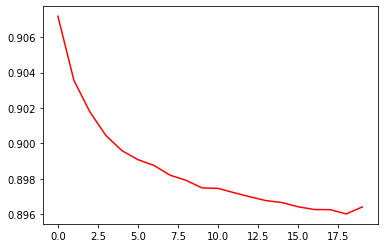

In [41]:
plt.plot(loss_list,color = 'r')

In [52]:
alphanet = alphanet.cpu()
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())

In [53]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_12.22_1d_return_normalized
0,2019-03-01 09:30:00,1,0.210976,-0.020684
1,2019-03-04 09:30:00,1,0.313131,-0.072253
2,2019-03-05 09:30:00,1,-0.643310,-0.060761
3,2019-03-06 09:30:00,1,-0.500139,-0.020684
4,2019-03-07 09:30:00,1,-1.180464,-0.087666
...,...,...,...,...
885421,2020-02-24 09:30:00,688399,1.771073,-0.020684
885422,2020-02-25 09:30:00,688399,1.498794,-0.020684
885423,2020-02-26 09:30:00,688399,-1.733627,-0.020684
885424,2020-02-27 09:30:00,688399,0.522789,-0.028828


In [35]:
# params = list(alphanet.named_parameters())
# len(params)
(name, param) = params[4]
print(name)
# print(param.grad)
# print('-------------------------------------------------')
# (name2, param2) = params[29]
# print(name2)
# print(param2.grad)
# print('----------------------------------------------------')
# (name1, param1) = params[30]
# print(name1)
# print(param1.grad)

out.weight


In [54]:
test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]

'2019-03-01_2020-03-01.par'

In [55]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])